## Binary addition with a non-linear RNN

This part will cover:
* Store data in [tensor](http://peterroelants.github.io/posts/rnn_implementation_part02/#Dataset)
* Optimization with [Rmsprop and Nesterov momentum](http://peterroelants.github.io/posts/rnn_implementation_part02/#Rmsprop-with-momentum-optimisation)

While the [first part](http://peterroelants.github.io/posts/rnn_implementation_part01/) of this tutorial described a simple linear recurrent network, this tutorial will describe an RNN with non-linear transfer functions that is able to learn how to perform [binary addition](https://en.wikipedia.org/wiki/Binary_number#Addition) from examples.

First we import the libraries we need and define the dataset.

In [1]:
# Python imports
import itertools
import numpy as np # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

## Dataset

This tutorial uses a dataset of 2000 training samples to train the RNN that can be created with the `create_dataset` method defined below. Each sample consists of two 6-bit input numbers ($x_{i1}$, $x_{i2}$) padded with a 0 to make it 7 characters long, and a 7-bit target number ($t_{i}$) so that $t_{i} = x_{i1} + x_{i2}$ ($i$ is the sample index). The numbers are represented as [binary numbers](https://en.wikipedia.org/wiki/Binary_number) with the [most significant bit](https://en.wikipedia.org/wiki/Most_significant_bit) on the right (least significant bit first). This is so that our RNN can perform the addition form left to right.

The input and target vectors are stored in a 3th-order tensor. A [tensor](https://en.wikipedia.org/wiki/Tensor) is a generalisation of vectors and matrices, a vector is a 1st-order tensor, a matrix is a 2nd-order tensor. The order of a tensor is the dimensionality of the array data structure needed to represent it.   
The dimensions of our training data (`X_train`, `T_train`) are printed after the creation of the dataset below. The first order of our data tensors goes over all the samples (2000 samples), the second order goes over the variables per unit of time (7 timesteps), and the third order goes over the variables for each timestep and sample (e.g. input variables $x_{ik1}$, $x_{ik2}$ with $i$ the sample index and $k$ the timestep). The input tensor `X_train` is visualised in the following figure:

![Visualisation of input tensor X](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_Tensor.png)

The following code block initialises the dataset.

In [2]:
# Create dataset
nb_train = 2000  # Number of training samples
# Addition of 2 n-bit numbers can result in a n+1 bit number
sequence_len = 7  # Length of the binary sequence

def create_dataset(nb_samples, sequence_len):
    """Create a dataset for binary addition and return as input, targets."""
    max_int = 2**(sequence_len-1) # Maximum integer that can be added
    format_str = '{:0' + str(sequence_len) + 'b}' # Transform integer in binary format
    nb_inputs = 2  # Add 2 binary numbers
    nb_outputs = 1  # Result is 1 binary number
    X = np.zeros((nb_samples, sequence_len, nb_inputs))  # Input samples
    T = np.zeros((nb_samples, sequence_len, nb_outputs))  # Target samples
    # Fill up the input and target matrix
    for i in xrange(nb_samples):
        # Generate random numbers to add
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)
        # Fill current input and target row.
        # Note that binary numbers are added from right to left, but our RNN reads 
        #  from left to right, so reverse the sequence.
        X[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1)]))
        X[i,:,1] = list(reversed([int(b) for b in format_str.format(nb2)]))
        T[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1+nb2)]))
    return X, T

# Create training samples
X_train, T_train = create_dataset(nb_train, sequence_len)
print('X_train shape: {0}'.format(X_train.shape))
print('T_train shape: {0}'.format(T_train.shape))

X_train shape: (2000, 7, 2)
T_train shape: (2000, 7, 1)


### Binary addition

Performing binary addition is a good [toy problem](https://www.cs.toronto.edu/~hinton/csc2535/notes/lec10new.pdf) to illustrate how recurrent neural networks process input streams into output streams. The network needs to learn how to carry a bit to the next state (memory) and when to output a 0 or 1 dependent on the input and state.

The following code prints a visualisation of the inputs and target output we want our network to produce.

In [3]:
# Show an example input and target
def printSample(x1, x2, t, y=None):
    """Print a sample in a more visual way."""
    x1 = ''.join([str(int(d)) for d in x1])
    x2 = ''.join([str(int(d)) for d in x2])
    t = ''.join([str(int(d[0])) for d in t])
    if not y is None:
        y = ''.join([str(int(d[0])) for d in y])
    print('x1:   {:s}   {:2d}'.format(x1, int(''.join(reversed(x1)), 2)))
    print('x2: + {:s}   {:2d} '.format(x2, int(''.join(reversed(x2)), 2)))
    print('      -------   --')
    print('t:  = {:s}   {:2d}'.format(t, int(''.join(reversed(t)), 2)))
    if not y is None:
        print('y:  = {:s}'.format(y))
    
# Print the first sample
printSample(X_train[0,:,0], X_train[0,:,1], T_train[0,:,:])

x1:   1010010   37
x2: + 1101010   43 
      -------   --
t:  = 0000101   80


## Recurrent neural network architecture

Our recurrent network will take 2 input variables for each sample for each timepoint, transform them to states, and output a single probability that the current output is $1$ (instead of $0$). The input is transformed into the states of the RNN where it can hold information so the network knows what to output the next timestep.

There are many ways to visualise the RNN we are going to build. We can visualise the network as in the [previous part](http://peterroelants.github.io/posts/rnn_implementation_part01/) of our tutorial and unfold the processing of each input, state-update and output of a single timestep separately from the other timesteps. 

![Structure of the RNN](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png)

Or we can view the processing of the full input, state-updates, and full output seperately from each other. The full input tensor can be [mapped](https://en.wikipedia.org/wiki/Map_%28higher-order_function%29) in parallel to be used directly in the RNN state updates. And also the RNN states can be mapped in parallel to the output of each timestep.

![Structure of the RNN tensor processing](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_2.png)

The steps are abstracted in different classes below. Each class has a `forward` method that performs the [forward steps](http://peterroelants.github.io/posts/neural_network_implementation_part03/#1.-Forward-step) of backpropagation, and a `backward` method that perform the [backward](http://peterroelants.github.io/posts/neural_network_implementation_part03/#2.-Backward-step) steps of backpropagation.

### Processing of input and output tensors


#### Linear transformation

Neural networks typically transform input vectors by matrix multiplication and vector addition followed by a non-linear transfer function. The 2-dimensional input vectors to our network ($x_{ik1}$, $x_{ik2}$) are transformed by a $2 \times 3$ weight matrix and a bias vector of size 3. Before they can be added to the states of the RNN. The 3-dimensional state vectors are transformed to a 1-dimensional output vector by a $3 \times 1$ weight matrix and a bias vector of size 1 to give the output probabilities.

Since we want to process all inputs for each sample and each timestep in one computation we can use the numpy [`tensordot`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.tensordot.html) function to perform the dot products. This function takes 2 tensors and the axes that need to be aggregated by summation between the elements and a product of the result. For example the transformation of input X ($2000 \times 7 \times 2$) to the states S ($2000 \times 7 \times 3$) with the help of matrix W ($2 \times 3$) can be done by `S = tensordot(X, W, axes=((-1),(0)))`. This method will sum the elements of the last order (-1) of X with the elements of the first order (0) of W and multiply them together. This is the same as doing the matrix dot product for each [$x_{ik1}$, $x_{ik2}$] vector with W. `tensordot` can then make sure that the underlying computations can be done efficiently and in parallel.

These linear tensor transformations are used to transform the input X to the states S, and from the states S to the output Y. This linear transformation, together with its gradient is implemented in the `TensorLinear` class below. Note that the weights are initialized by sampling uniformly between $\pm \sqrt{6.0 / (n_{in} + n_{out})}$ [as suggested by X. Glorot](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf).


#### Logistic classification

[Logistic classification](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo01/) is used to output the probability that the output at current time step k is 1. This function together with its cost and gradient is implemented in the `LogisticClassifier` class below.

In [4]:
# Define the linear tensor transformation layer
class TensorLinear(object):
    """The linear tensor layer applies a linear tensor dot product and a bias to its input."""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        """Initialse the weight W and bias b parameters."""
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)  # Bias paramters
        self.bpAxes = tuple(range(tensor_order-1))  # Axes summed over in backprop

    def forward(self, X):
        """Perform forward step transformation with the help of a tensor product."""
        # Same as: Y[i,j,:] = np.dot(X[i,j,:], self.W) + self.b (for i,j in X.shape[0:1])
        # Same as: Y = np.einsum('ijk,kl->ijl', X, self.W) + self.b
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """Return the gradient of the parmeters and the inputs of this layer."""
        # Same as: gW = np.einsum('ijk,ijl->kl', X, gY)
        # Same as: gW += np.dot(X[:,j,:].T, gY[:,j,:]) (for i,j in X.shape[0:1])
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        # Same as: gX = np.einsum('ijk,kl->ijl', gY, self.W.T)
        # Same as: gX[i,j,:] = np.dot(gY[i,j,:], self.W.T) (for i,j in gY.shape[0:1])
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB

In [5]:
# Define the logistic classifier layer
class LogisticClassifier(object):
    """The logistic layer applies the logistic function to its inputs."""
   
    def forward(self, X):
        """Perform the forward step transformation."""
        return 1 / (1 + np.exp(-X))
    
    def backward(self, Y, T):
        """Return the gradient with respect to the cost function at the inputs of this layer."""
        # Normalise of the number of samples and sequence length.
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def cost(self, Y, T):
        """Compute the cost at the output."""
        # Normalise of the number of samples and sequence length.
        # Add a small number (1e-99) because Y can become 0 if the network learns
        #  to perfectly predict the output. log(0) is undefined.
        return - np.sum(np.multiply(T, np.log(Y+1e-99)) + np.multiply((1-T), np.log(1-Y+1e-99))) / (Y.shape[0] * Y.shape[1])

### Unfolding the recurrent states

Just as in the [previous part]((http://peterroelants.github.io/posts/rnn_implementation_part01/) of this tutorial the recurrent states need to be unfolded through time. This unfolding during [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) is done by the `RecurrentStateUnfold` class. This class holds the shared weight and bias parameters used to update each state, as well as the initial state that is also treated as a parameter and optimized during backpropagation.

The `forward` method of `RecurrentStateUnfold` iteratively updates the states through time and returns the resulting state tensor. The `backward` method propagates the gradients at the outputs of each state backwards through time. Note that at each time $k$ the gradient coming from the output Y needs to be added with the gradient coming from the previous state at time $k+1$. The gradients of the weight and bias parameters are summed over all timestep since they are shared parameters in each state update. The final state gradient at time $k=0$ is used to optimise the initial state $S_0$ since the gradient of the inital state is $\partial \xi / \partial S_{0}$.

`RecurrentStateUnfold` makes use of the `RecurrentStateUpdate` class. The `forward` method of this class combines the transformed input and state at time $k-1$ to output state $k$. The `backward` method propagates the gradient backwards through time for one timestep and calculates the gradients of the parameters of this timestep. The non-linear transfer function used in `RecurrentStateUpdate` is the [hyperbolic tangent](https://en.wikipedia.org/wiki/Hyperbolic_function) (tanh) function. This function, like the logistic function, is a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) that goes from $-1$ to $+1$. The [tanh function]( https://theclevermachine.wordpress.com/tag/tanh-function/) is chosen because the maximum gradient of this function is higher than the maximum gradient of the [logistic function](http://peterroelants.github.io/posts/neural_network_implementation_part02/#Logistic-function) which make vanishing gradients less likely. This tanh transfer function is implemented in the `TanH` class.

In [6]:
# Define tanh layer
class TanH(object):
    """TanH applies the tanh function to its inputs."""
    
    def forward(self, X):
        """Perform the forward step transformation."""
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        gTanh = 1.0 - np.power(Y,2)
        return np.multiply(gTanh, output_grad)

In [7]:
# Define internal state update layer
class RecurrentStateUpdate(object):
    """Update a given state."""
    def __init__(self, nbStates, W, b):
        """Initialse the linear transformation and tanh transfer function."""
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """Return state k+1 from input and state k."""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Return the gradient of the parmeters and the inputs of this layer."""
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

In [8]:
# Define layer that unfolds the states over time
class RecurrentStateUnfold(object):
    """Unfold the recurrent states."""
    def __init__(self, nbStates, nbTimesteps):
        " Initialse the shared parameters, the inital state and state update function."
        a = np.sqrt(6.0 / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))  # Shared bias
        self.S0 = np.zeros(nbStates)  # Initial state
        self.nbTimesteps = nbTimesteps  # Timesteps to unfold
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)  # State update function
        
    def forward(self, X):
        """Iteratively apply forward step to all states."""
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))  # State tensor
        S[:,0,:] = self.S0  # Set initial state
        for k in range(self.nbTimesteps):
            # Update the states iteratively
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """Return the gradient of the parmeters and the inputs of this layer."""
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])  # Initialise gradient of state outputs
        gZ = np.zeros_like(X)  # Initialse gradient tensor for state inputs
        gWSum = np.zeros_like(self.W)  # Initialise weight gradients
        gBSum = np.zeros_like(self.b)  # Initialse bias gradients
        # Propagate the gradients iteratively
        for k in range(self.nbTimesteps-1, -1, -1):
            # Gradient at state output is gradient from previous state plus gradient from output
            gSk += gY[:,k,:]
            # Propgate the gradient back through one state
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Update total weight gradient
            gBSum += gB  # Update total bias gradient
        gS0 = np.sum(gSk, axis=0)  # Get gradient of initial state over all samples
        return gZ, gWSum, gBSum, gS0

### The full network

The full network that will be trained to perform binary addition of two number is defined in the `RnnBinaryAdder` class below. It initialises all the layers upon creation. The `forward` method performs the full backpropagation forward step through all layers and timesteps and returns the intermediary outputs. The `backward` method performs the backward step through all layers and timesteps and returns the gradients of all the parameters. The `getParamGrads` method performs both steps and returns the gradients of the parameters in a list. The order of this list corresponds to the order of the iterator returned by `get_params_iter`. The parameters returned in the iterator of that last method are the same as the parameters of the network and can be used to change the parameters of the network manually.

In [9]:
# Define the full network
class RnnBinaryAdder(object):
    """RNN to perform binary addition of 2 numbers."""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, sequence_len):
        """Initialse the network layers."""
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)  # Input layer
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)  # Recurrent layer
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)  # Linear output transform
        self.classifier = LogisticClassifier()  # Classification output
        
    def forward(self, X):
        """Perform the forward propagation of input X through all layers."""
        recIn = self.tensorInput.forward(X)  # Linear input transformation
        # Forward propagate through time and return states
        S = self.rnnUnfold.forward(recIn)
        Z = self.tensorOutput.forward(S[:,1:sequence_len+1,:])  # Linear output transformation
        Y = self.classifier.forward(Z)  # Get classification probabilities
        # Return: input to recurrent layer, states, input to classifier, output
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """Perform the backward propagation through all layers.
        Input: input samples, network output, intput to recurrent layer, states, targets."""
        gZ = self.classifier.backward(Y, T)  # Get output gradient
        gRecOut, gWout, gBout = self.tensorOutput.backward(S[:,1:sequence_len+1,:], gZ)
        # Propagate gradient backwards through time
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        # Return the parameter gradients of: linear output weights, linear output bias,
        #  recursive weights, recursive bias, linear input weights, linear input bias, initial state.
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        """Get the output probabilities of input X."""
        recIn, S, Z, Y = self.forward(X)
        return Y  # Only return the output.
    
    def getBinaryOutput(self, X):
        """Get the binary output of input X."""
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        """Return the gradients with respect to input X and target T as a list.
        The list has the same order as the get_params_iter iterator."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def cost(self, Y, T):
        """Return the cost of input X w.r.t. targets T."""
        return self.classifier.cost(Y, T)
    
    def get_params_iter(self):
        """Return an iterator over the parameters.
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

## Gradient Checking

As in [part 4 of our previous tutorial on feedforward nets](http://peterroelants.github.io/posts/neural_network_implementation_part04/#Gradient-checking) the gradient computed by backpropagation is compared with the [numerical gradient](https://en.wikipedia.org/wiki/Numerical_differentiation) to assert that there are no bugs in the code to compute the gradients. This is done by the code below.

In [10]:
# Do gradient checking
# Define an RNN to test
RNN = RnnBinaryAdder(2, 1, 3, sequence_len)
# Get the gradients of the parameters from a subset of the data
backprop_grads = RNN.getParamGrads(X_train[0:100,:,:], T_train[0:100,:,:])

eps = 1e-7  # Set the small change to compute the numerical gradient
# Compute the numerical gradients of the parameters in all layers.
for p_idx, param in enumerate(RNN.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    param += eps
    plus_cost = RNN.cost(RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])
    # - eps
    param -= 2 * eps
    min_cost = RNN.cost(RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])
    # reset param value
    param += eps
    # calculate numerical gradient
    grad_num = (plus_cost - min_cost)/(2*eps)
    # Raise error if the numerical grade is not close to the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


## Rmsprop with momentum optimisation

While the [first part](http://peterroelants.github.io/posts/rnn_implementation_part01/) of this tutorial used [Rprop](https://en.wikipedia.org/wiki/Rprop) to optimise the network, this part will use the [Rmsprop](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) algorithm with [Nesterov's accelerated gradient](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf) to perform the optimisation. We replaced the Rprop algorithm because Rprop doesn't work well with [minibatches](http://peterroelants.github.io/posts/neural_network_implementation_part05/#Stochastic-gradient-descent-backpropagation) due to the stochastic nature of the error surface that can result in sign changes of the gradient.

The Rmsprop algorithm was inspired by the Rprop algorithm. It keeps a [moving average](https://en.wikipedia.org/wiki/Moving_average) (MA) of the squared gradient for each parameter $\theta$ ($MA = \lambda * MA + (1-\lambda) * (\partial \xi / \partial \theta)^2$, with $\lambda$ the moving average hyperparameter). The gradient is then normalised by dividing by the square root of this moving average (`maSquare` = $(\partial \xi / \partial \theta)/\sqrt{MA}$). This normalised gradient is then used to update the parameters. Note that if $\lambda=0$ the gradient is reduced to its sign.

This transformed gradient is not used directly to update the parameters, but it is used to update a velocity parameter (`Vs`) for each parameter of the network. This parameter is similar to the velocity parameter from our [previous tutorial](http://peterroelants.github.io/posts/neural_network_implementation_part04/#Backpropagation-updates-with-momentum) but it is used in a slightly different way. Nesterov's accelerated gradient is different from regular momentum in that it applies updates in a different way. While the regular momentum algorithm calculates the gradient at the beginning of the iteration, updates the velocity and moves the parameters according to this velocity, Nesterov's accelerated gradient moves the parameters according to the reduced velocity, then calculates the gradients, updates the velocity, and then moves again according to the local gradient. This has as benefit that the gradient is more informative to do the local update, and can correct for a bad velocity update. The Nesterov updates can be described as:

$$\begin{split}
V_{i+1} & = \lambda V_i - \mu \nabla(\theta_i + \lambda V_i) \\
\theta_{i+1} & = \theta_i + V_{i+1} \\
\end{split}$$

With $\nabla(\theta)$ the local gradient at position $\theta$ in the parameter space. And $i$ the iteration number. This formula can be visualised as in the following illustration (See [Sutskever I.](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf)):

![Illustration of Nesterov Momentum updates](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/NesterovMomentum.png)

Note that the training converges to a cost of 0. This convergence is actually not guaranteed. If the parameters of the network start out in a bad position the network might convert to a local minimum that is far from the global minimum. The training is also sensitive to the meta parameters `lmbd`, `learning_rate`, `momentum_term`, `eps`. Try rerunning this yourself to see how many times it actually converges.

In [11]:
# Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.05  # Learning rate
momentum_term = 0.80  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero
mb_size = 100  # Size of the minibatches (number of samples)

# Create the network
nb_of_states = 3  # Number of states in the recurrent layer
RNN = RnnBinaryAdder(2, 1, nb_of_states, sequence_len)
# Set the initial parameters
nbParameters =  sum(1 for _ in RNN.get_params_iter())  # Number of parameters in the network
maSquare = [0.0 for _ in range(nbParameters)]  # Rmsprop moving average
Vs = [0.0 for _ in range(nbParameters)]  # Velocity

# Create a list of minibatch costs to be plotted
ls_of_costs = [RNN.cost(RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])]
# Iterate over some iterations
for i in range(5):
    # Iterate over all the minibatches
    for mb in range(nb_train/mb_size):
        X_mb = X_train[mb:mb+mb_size,:,:]  # Input minibatch
        T_mb = T_train[mb:mb+mb_size,:,:]  # Target minibatch
        V_tmp = [v * momentum_term for v in Vs]
        # Update each parameters according to previous gradient
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        # Get gradients after following old velocity
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)  # Get the parameter gradients    
        # Update each parameter seperately
        for pIdx, P in enumerate(RNN.get_params_iter()):
            # Update the Rmsprop moving averages
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (1-lmbd) * backprop_grads[pIdx]**2
            # Calculate the Rmsprop normalised gradient
            pGradNorm = learning_rate * backprop_grads[pIdx] / np.sqrt(maSquare[pIdx] + eps)
            # Update the momentum velocity
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm     
            P -= pGradNorm   # Update the parameter
        ls_of_costs.append(RNN.cost(RNN.getOutput(X_mb), T_mb))  # Add cost to list to plot

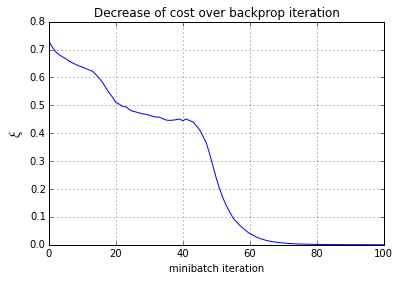

In [12]:
# Plot the cost over the iterations
plt.plot(ls_of_costs, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

## Test examples

The figure above shows that the training converged to a cost of 0. We expect the network to have learned how to perfectly do binary addition for our training examples. If we put some independent test cases through the network and print them out we can see that the network also outputs the correct output for these test cases.

In [13]:
# Create test samples
nb_test = 5
Xtest, Ttest = create_dataset(nb_test, sequence_len)
# Push test data through network
Y = RNN.getBinaryOutput(Xtest)
Yf = RNN.getOutput(Xtest)

# Print out all test examples
for i in range(Xtest.shape[0]):
    printSample(Xtest[i,:,0], Xtest[i,:,1], Ttest[i,:,:], Y[i,:,:])
    print ''

x1:   0100010   34
x2: + 1100100   19 
      -------   --
t:  = 1010110   53
y:  = 1010110

x1:   1010100   21
x2: + 1110100   23 
      -------   --
t:  = 0011010   44
y:  = 0011010

x1:   1111010   47
x2: + 0000000    0 
      -------   --
t:  = 1111010   47
y:  = 1111010

x1:   1000000    1
x2: + 1111110   63 
      -------   --
t:  = 0000001   64
y:  = 0000001

x1:   1010100   21
x2: + 1010100   21 
      -------   --
t:  = 0101010   42
y:  = 0101010



This post at [peterroelants.github.io](http://peterroelants.github.io/posts/rnn_implementation_part02/) is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/RNN_implementation/rnn_implementation_part02.ipynb)